In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
# deep_dipole_coordinates = (
#     [ 300,  750, 1200, 300, 1200, 1750],  # µm
#     [ 300, 1000, 1700, 1600, 300, 1000],  # µm
#     [-600, -600, -600, -600, -600, -600],  # µm
# )
# deep_dipole_moments = mg.angles_to_vector(
#     inclination=[-90, 90, -90, 90, 90, -90],
#     declination=[0, 0, 0, 0, 0, 0],
#     amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
# )

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 50
sourcers2 = 150
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(0, 2000, sourcers1),np.random.randint(0, 2000, sourcers2)]),  # µm
    np.concatenate([np.random.randint(0, 2000, sourcers1),np.random.randint(0, 2000, sourcers2)]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2)]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(35, 5, sourcers1),np.random.normal(0, 50, sourcers2)]),
    declination=np.concatenate([np.random.normal(340, 5, sourcers1),np.random.normal(0, 140, sourcers2)]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1))*1.0E-16, abs(np.random.normal(0, 100, sourcers2))*1.0E-15]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(dipole_coordinates)

(array([ 867,  206, 1725,  998, 1142, 1424,   73, 1032,  740, 1767, 1982,
        411,  624,  670, 1744, 1543,  204, 1935, 1137, 1461, 1104,   27,
       1068,  205, 1739, 1089, 1455, 1566, 1110, 1661,  146, 1278,  377,
       1673, 1386,   41, 1470, 1921,  210,  103, 1168,  974,    5, 1850,
        768,  900, 1134,  676, 1897, 1715,  539,  799,  770,  324,  294,
       1129,  147,  274,  881,  245, 1159,  868,  364, 1645, 1694,  190,
       1803, 1515,  835, 1404, 1473,  183,  387,  603,   78, 1947, 1949,
        801,  729,  853,  391,  528, 1118,   14,  986, 1823,  265, 1574,
       1839,  144, 1413,  418,  685, 1723,  408, 1421,  374, 1259,  744,
         31, 1056,  332, 1196, 1925,  398,  175,   94,  850,  896, 1159,
       1238,  528, 1088,  264, 1498,   44,  638,  677,   94, 1483,  901,
        745,  918,  180,  837, 1746, 1724, 1883, 1053,  216,  632,  225,
        476,  719, 1862,  547,  879,  276,  177,  511,  584, 1696, 1234,
       1037, 1244,  507,  751, 1170, 1332, 1361, 1

In [5]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}


# Add some random noise to make it more realistic.
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)
# Add a positive shift to the data 
data.bz.values += 2000 # nT

data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 8MB 2.013e+03 1.945e+03 ... 1.983e+03 1.97e+03

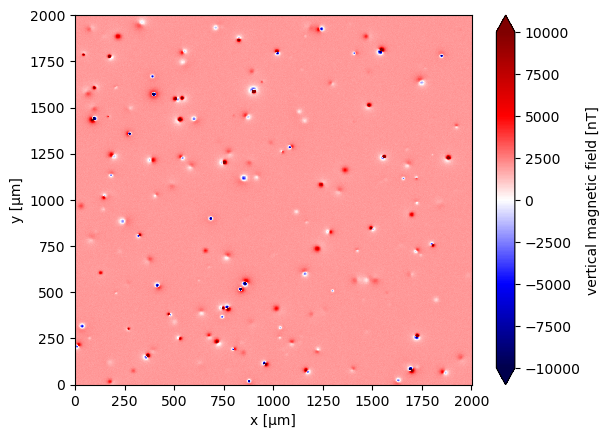

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

Add a polynomial shift to the data

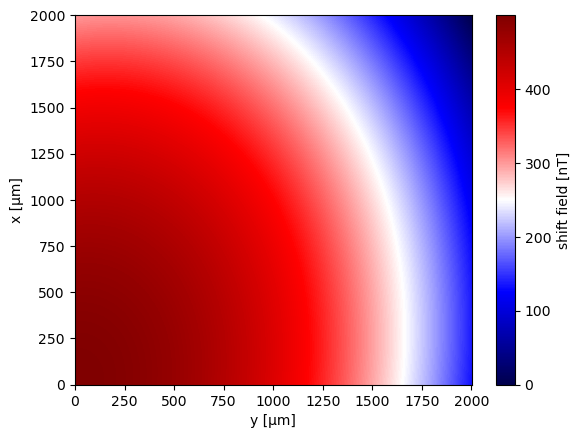

In [7]:
# a, b, c, d, e, f, g = 1, 2, -1, 3, -2, 1, 0.5
# a, b, c, d, e, f, g = 1.0, 0.5, 0.2, -1.0, 0.8, -2.0, 0.3
# pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
# data['poly'] = (pol/pol.values.max())*2000


a, b, c, d, e, f, g = 3, 5, -1, 3, -5, 10, 0.5
pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
data['poly'] = abs((pol/pol.values.max())-(pol/pol.values).max())*500

data.poly.attrs = {"long_name": "shift field", "units": "nT"}


# data.bz.values += data.poly.values 

data.poly.plot.pcolormesh(cmap="seismic")#, vmax=10000, vmin=-10000)

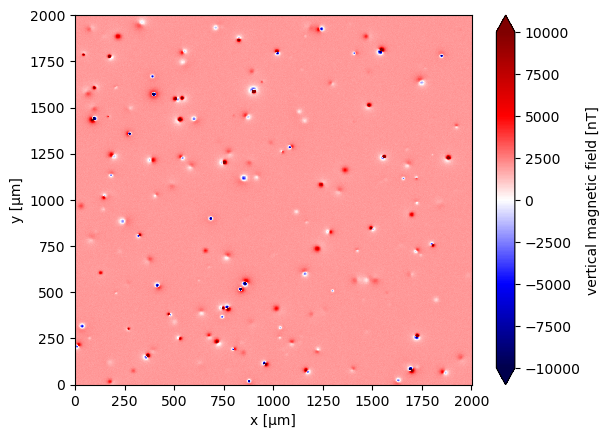

In [8]:
# median = np.median(data.bz.values)
# data.bz.values -= median

data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional Separation

In [9]:
# regional = vd.Trend(degree=1).fit(coordinates, data.bz.values)
# data = data.assign(
#     regional_predicted=regional.predict((data.x, data.y)),
# )
# data.bz.values -= data.regional_predicted.values
# data


data_table = vd.grid_to_table(data)

regional = vd.Trend(degree=1).fit((data_table.x, data_table.y), data.bz.values.ravel())

shape = data.bz.shape
regional_predicted=regional.predict((data_table.x, data_table.y))
regional_predicted = np.reshape(regional_predicted, shape)


data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

# data.bz.values -= data.regional_predicted.values

data

<xarray.Dataset> Size: 32MB
Dimensions:             (y: 1001, x: 1001)
Coordinates:
  * x                   (x) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
  * y                   (y) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
    z                   (y, x) float64 8MB 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz                  (y, x) float64 8MB 2.013e+03 1.945e+03 ... 1.97e+03
    poly                (x, y) float64 8MB 500.0 500.0 500.0 ... 0.6662 0.0
    regional_predicted  (y, x) float64 8MB 1.999e+03 1.999e+03 ... 2.001e+03

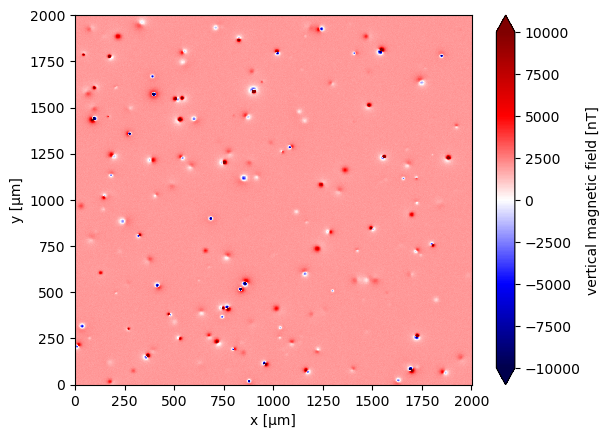

In [10]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [11]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 1.997e+03 1.997e+03 ... 1.996e+03 1.997e+03

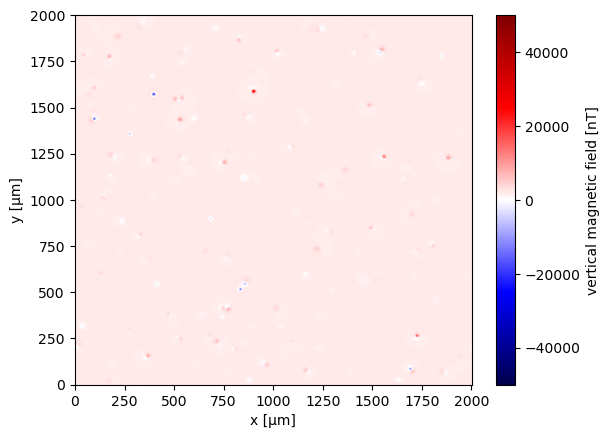

In [12]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [13]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 48MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 1.997e+03 1.997e+03 ... 1.996e+03 1.997e+03
    tga      (y, x) float64 8MB 0.6087 1.314 1.98 1.651 ... 1.003 0.6237 0.3591
    x_deriv  (y, x) float64 8MB 0.2506 0.3597 0.2603 ... -0.2329 0.06704 0.1893
    y_deriv  (y, x) float64 8MB -0.5232 -1.252 -1.622 ... 0.5813 0.4064 -0.03337
    z_deriv  (y, x) float64 8MB 0.1843 -0.1711 -1.104 ... 0.7829 0.4683 0.3034

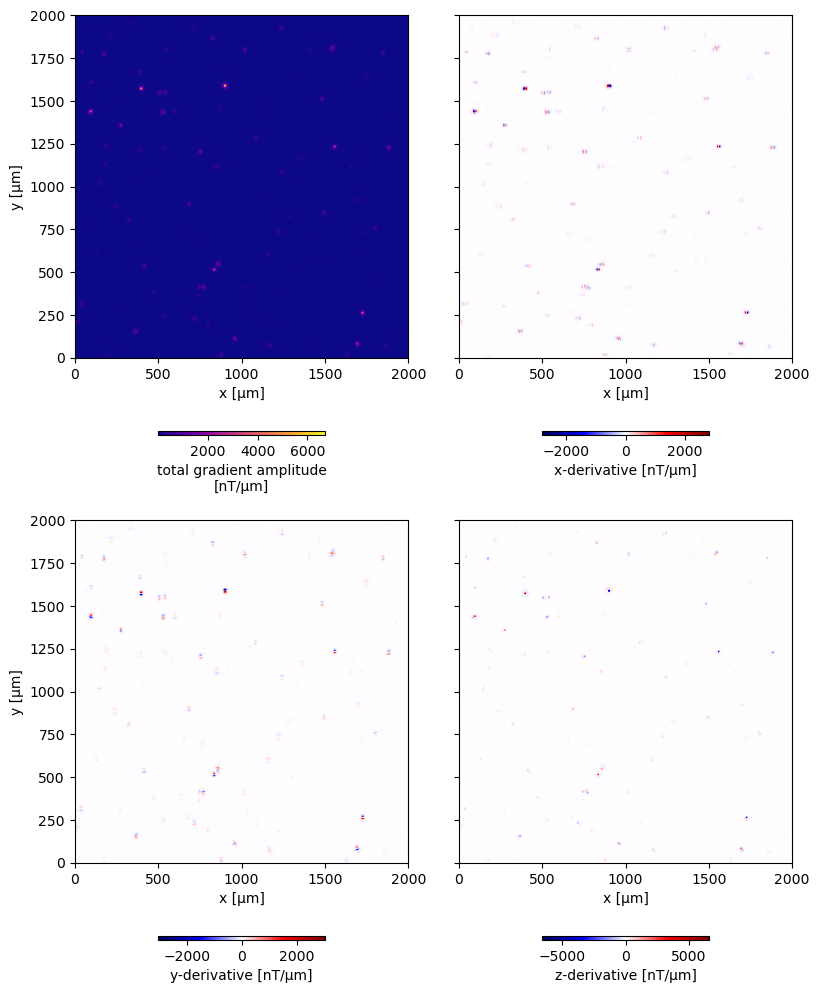

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [15]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

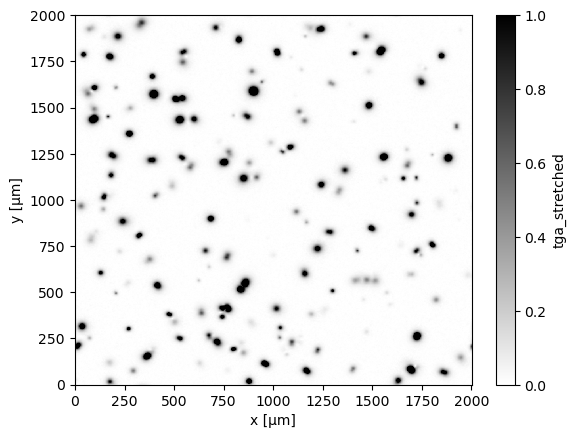

In [16]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [17]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.0,
    threshold=0.09,
    overlap=0.3,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [18]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

123 potential sources detected within 2.4003 seconds


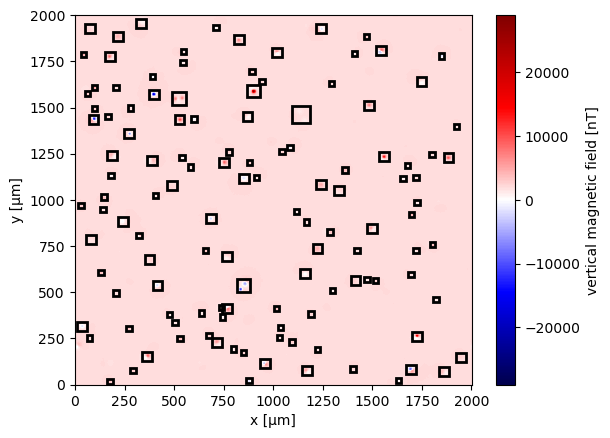

In [19]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [20]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#     bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [21]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

123 euler positions and dipole moments estimated within 0.89 seconds


Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [22]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.42150053,  0.42546362,  0.41785209,  0.31550378,  0.42486288,
        0.3857971 ,  0.34640174,  0.33325807,  0.31917603,  0.39609983,
        0.36045245,  0.38960909,  0.42079848,  0.39765399,  0.47005934,
        0.35141086,  0.31572494,  0.3036887 ,  0.31646263,  0.35491625,
        0.28583174,  0.30508589,  0.14242372,  0.41558607,  0.45266046,
        0.33854186,  0.2878293 ,  0.41584509,  0.29098408,  0.34205656,
        0.41109464,  0.44071828,  0.41133406,  0.25468225,  0.75293712,
        0.54984762,  0.5175903 ,  0.12222451,  0.31865777,  0.25748412,
        0.24100036,  0.50321871, -0.679525  ,  0.54444822,  0.53095517,
        0.89011877,  0.26258178,  1.59994824,  0.45336675,  0.53336266,
        0.62691699,  0.25529319,  0.55722472,  0.39480185,  0.18331663,
        0.49792546,  0.83516844,  0.25264604,  0.2467492 ,  0.30862492,
        0.78997654,  0.55446486,  0.41702494,  0.35211302,  0.30855841,
        0.60189269,  0.45233402,  0.54440391,  1.70046685,  0.70

In [23]:
# Misfits alculation
direction_misfit = []
magnetic_moment_misfit = []

for estimated, true in zip(estimated_dipole_moments, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)

/tmp/ipykernel_16619/3758845858.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


# Iterative Euler deconvolution

In [24]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameters, obs_data, coordinates):
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    # de, dn = de_orig*mg.MICROMETER_TO_METER, dn_orig*mg.MICROMETER_TO_METER
    de, dn, du = parameters[0], parameters[1], parameters[2]
    mx, my, mz = parameters[3], parameters[4], parameters[5]
    
    e, n, u = coordinates[0], coordinates[1], coordinates[2]
    # print(mx)
    # bz = np.zeros(np.shape(obs_data))
    # for i in numba.prange(e.size):
    distance = choclo.utils.distance_cartesian(
            e,
            n,
            u,
            de,
            dn,
            du,
        )

    bz = constant *(mx*choclo.point.kernel_eu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+
        
          my*choclo.point.kernel_nu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+

          mz*choclo.point.kernel_uu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)
                   )
    
    Res = np.linalg.norm( (obs_data)-bz.ravel() )
    return(Res)

In [25]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [26]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')

    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

piorou

In [27]:
np.sum(estimated_dipole_moments_itr_euler, axis=0)

array([-9.01280016e-14,  6.47167492e-13,  7.22869340e-13])

In [28]:
minimization

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 50.72262480277953
             x: [ 1.000e+00  1.000e+00  1.195e+00  4.291e-01  1.798e-01
                 -9.813e-01]
           nit: 281
          nfev: 473
 final_simplex: (array([[ 1.000e+00,  1.000e+00, ...,  1.798e-01,
                        -9.813e-01],
                       [ 1.000e+00,  1.000e+00, ...,  1.798e-01,
                        -9.813e-01],
                       ...,
                       [ 1.000e+00,  1.000e+00, ...,  1.798e-01,
                        -9.813e-01],
                       [ 1.000e+00,  1.000e+00, ...,  1.798e-01,
                        -9.813e-01]]), array([ 5.072e+01,  5.072e+01,  5.072e+01,  5.072e+01,
                        5.072e+01,  5.072e+01,  5.072e+01]))

In [29]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 42.1801 seconds


In [30]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z           bz    z_deriv
0  1702.0  238.0  10.0  1643.279090   9.925831
1  1704.0  238.0  10.0  1597.276997  12.070430
2  1706.0  238.0  10.0  1545.951706  15.791186
3  1708.0  238.0  10.0  1490.783561  18.924241
4  1710.0  238.0  10.0  1431.950995  21.853811

In [31]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
print(positions_itr[:, 2])

[960.00095868 112.99445535  -2.00719261]


In [32]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

[693.6440997591301, 742.3559002408699, 205.64409975913003, 254.35590024086997]

27

[815.430335141991, 884.569664858009, 501.430335141991, 570.569664858009]

42

[489.430335141991, 558.569664858009, 1513.430335141991, 1582.569664858009]

45

[743.6440997591301, 792.3559002408699, 389.64409975913003, 438.35590024086997]

47

[725.857864376269, 754.142135623731, 401.85786437626905, 430.14213562373095]

71

[351.64409975913003, 400.35590024086997, 653.6440997591301, 702.3559002408699]

98

[191.85786437626905, 220.14213562373095, 481.85786437626905, 510.14213562373095]

101

[193.85786437626905, 222.14213562373095, 1593.857864376269, 1622.142135623731]

102

[1457.857864376269, 1486.142135623731, 553.857864376269, 582.142135623731]

103

[59.85786437626905, 88.14213562373095, 237.85786437626905, 266.14213562373095]

116

[1095.216570524852, 1184.783429475148, 1417.216570524852, 1506.783429475148]

121

[1787.857864376269, 1816.142135623731, 1229.857864376269, 1258.142135623731]

122

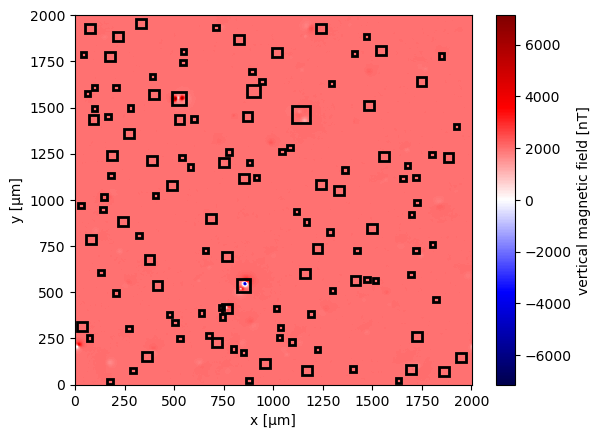

In [33]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

###################################################

# ax = plt.subplot(111)
# data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
# for window in windows:
#     rect = matplotlib.patches.Rectangle(
#         xy=[window[0], window[2]],
#         width=window[1] - window[0],
#         height=window[3] - window[2],
#         edgecolor="k",
#         fill=False,
#         linewidth=2,
#     )
#     ax.add_patch(rect)   

##################################################

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    print(window)
    print(index)
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    # # store the results with the itr Euler (without interfering sources)
    # print(estimated_dipole_moments_itr_euler[index])
    # print(positions_itr[:, index])
    # estimated_dipole_moments_itr_euler[index] = moment
    # positions_itr[:, index] = position

    # print(moment)
    # print(position)
    # print()
    # #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


In [34]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr))[1]
z_difference_itr = positions_itr[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr
# euler_r2_itr_cond


array([ 6.19841516e-03,  1.23794406e-02, -7.19261308e-03,  4.51322251e-02,
        1.68643004e-01,  6.70150917e-03, -7.92577420e-02,  2.36642534e-03,
        2.10204720e-02,  2.54063121e-02,  2.18217689e-02,  9.64458469e-03,
        1.24060455e-02,  2.25023652e-02,  1.10369601e-01,  8.30359323e-02,
        4.57950637e-02, -7.14366167e-02,  1.20440813e-02,  3.80767212e-02,
        6.22606771e-03, -1.12690640e-01, -7.15138049e-02, -7.33586137e-03,
        1.24141653e-01,  1.58542293e-01,  8.89942203e-02,  6.73960594e-02,
       -5.07146179e-02,  2.03734497e-02,  5.34145348e-02,  7.46161030e-02,
        1.74529646e-02,  1.00463775e-02,  3.78283292e-01,  2.57512408e-01,
        1.93709281e-01, -2.46342598e-01, -1.63911669e-01,  1.59818291e-02,
        2.41726485e-02,  1.61090248e-01, -1.30482318e+00,  8.00399774e-03,
        1.64270345e-01,  9.11500475e-01,  7.60993457e-02,  1.31905865e-01,
        7.90739860e-02,  1.94807839e-01,  2.41302091e-01,  4.85442094e-02,
        2.18839023e-01,  

# Comparison plots

## Euler comparison

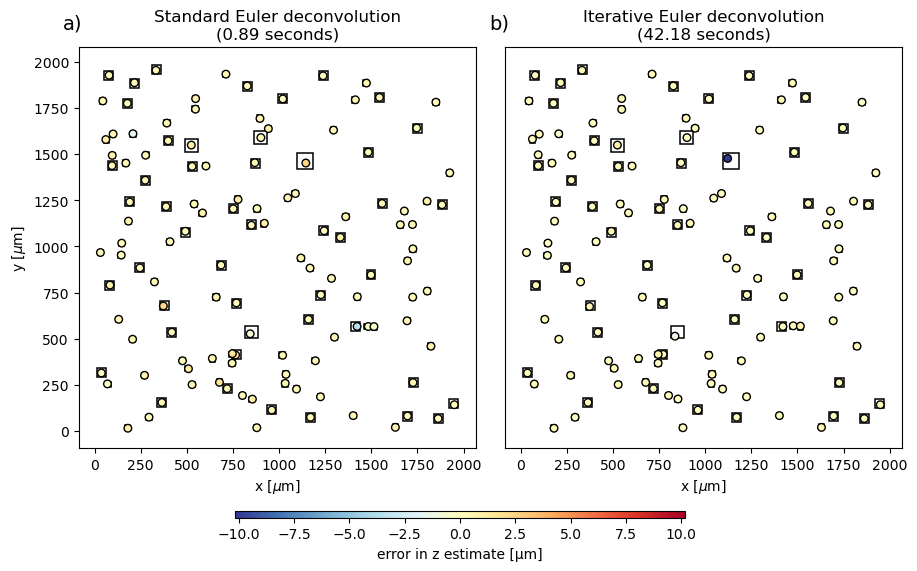

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((z_difference, z_difference_itr))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iterative Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

## Directions and Dipole Moments comparions

### Iterative Euler (withou interf. sources)

In [36]:
# Misfits alculation
direction_misfit_itr_euler = []
magnetic_moment_misfit_itr_euler = []

for estimated, true in zip(estimated_dipole_moments_itr_euler, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler.append(dir_misfit)
    magnetic_moment_misfit_itr_euler.append(magm_mom_misfit)

In [37]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

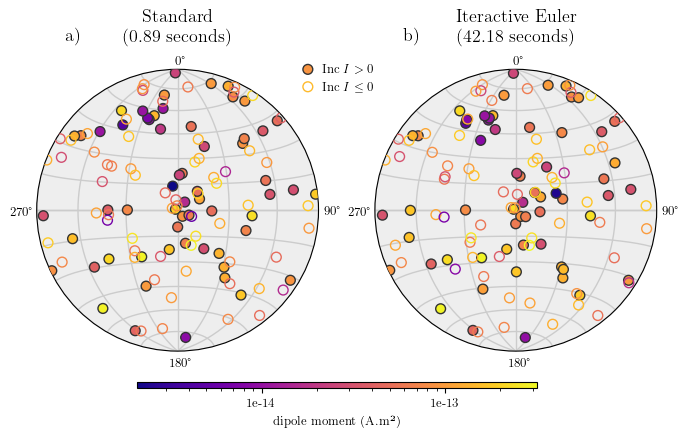

In [38]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

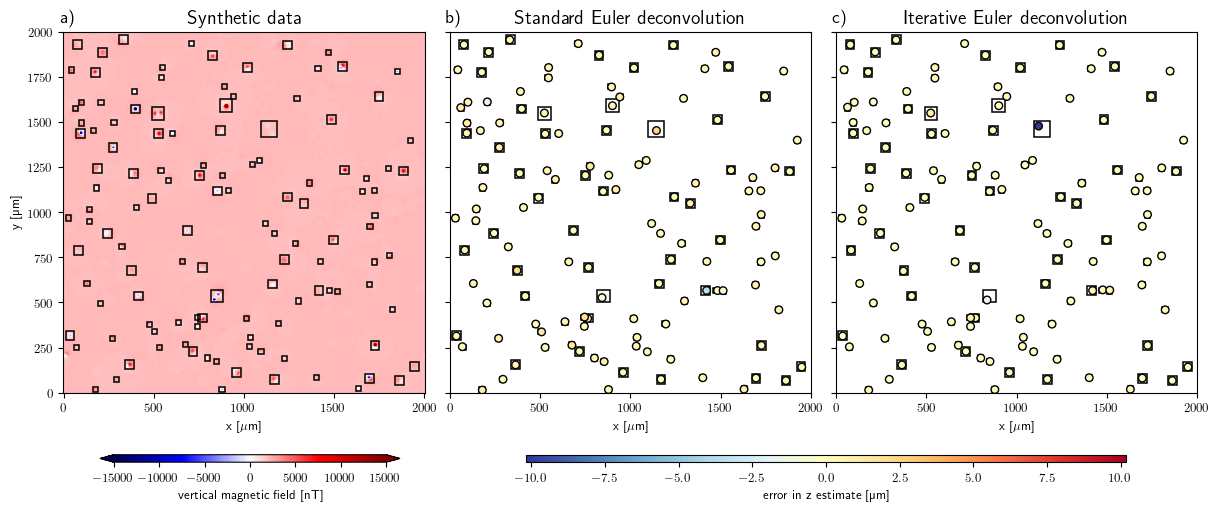

In [39]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference, z_difference_itr))

    ax = axes[1]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[2]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


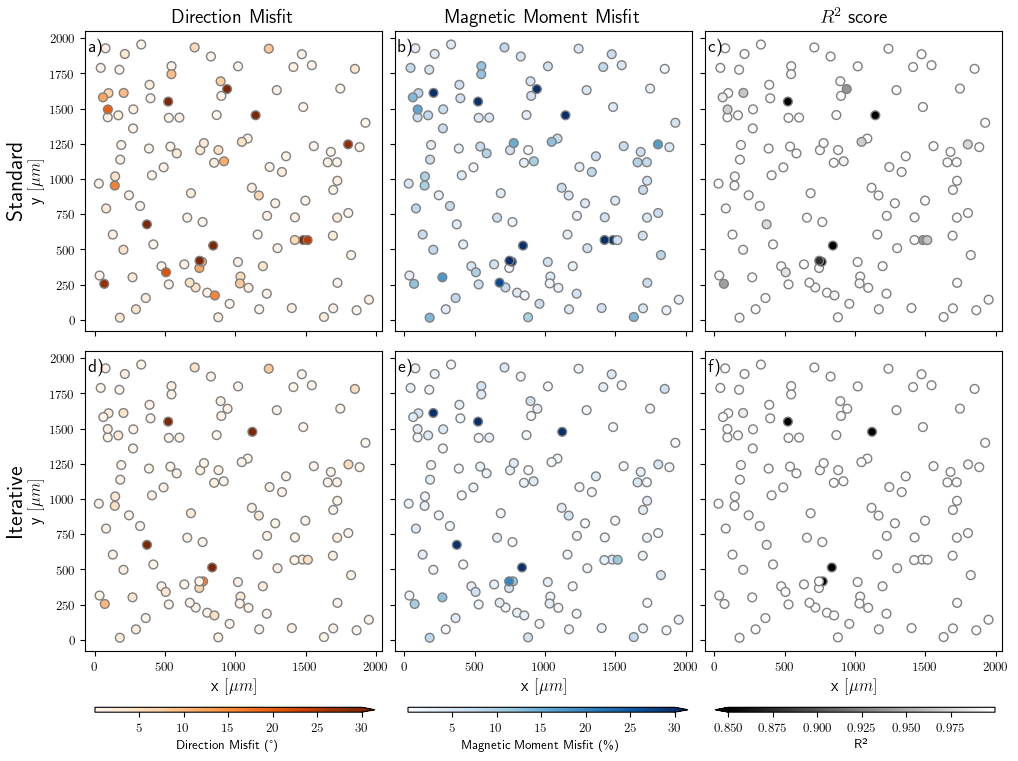

In [40]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_itr_euler, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_itr_euler, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_itr_euler, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iterative}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[3].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[4].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[5].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    fig.savefig(fig_dir / "inversion-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   

In [41]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


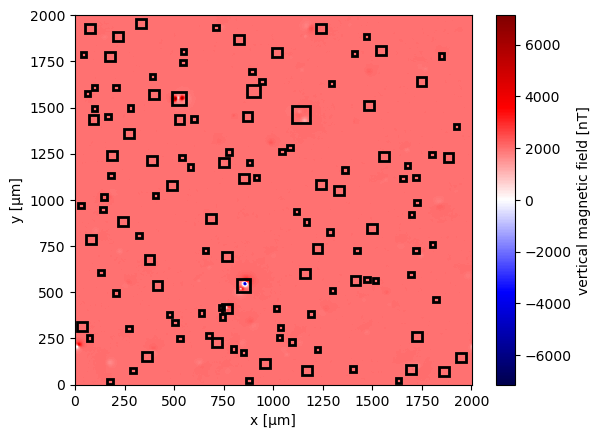

In [42]:
ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [43]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 48MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 1.998e+03 1.999e+03 ... 1.998e+03 1.998e+03
    tga      (y, x) float64 8MB 0.5218 1.257 1.94 1.647 ... 1.222 0.8136 0.4126
    x_deriv  (y, x) float64 8MB 0.1657 0.2887 0.2137 ... -0.2735 0.02962 0.1542
    y_deriv  (y, x) float64 8MB -0.4372 -1.219 -1.623 ... 0.8077 0.5992 0.1097
    z_deriv  (y, x) float64 8MB 0.2316 -0.1027 -1.04 ... 0.8748 0.5495 0.3666

In [44]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [45]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.09,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [46]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

123 potential sources detected within 2.3634 seconds


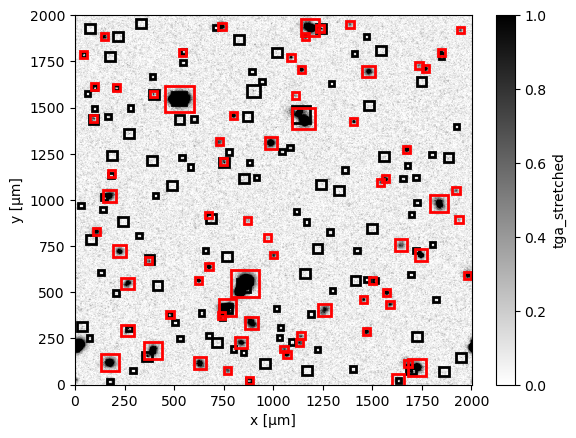

In [47]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [48]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[605.61522369 642.38477631 545.61522369 582.38477631]
[ 781.61522369  818.38477631 1439.61522369 1476.38477631]
[ 956.33732969 1019.66267031 1278.33732969 1341.66267031]
[131.05943568 220.94056432  75.05943568 164.94056432]
[657.61522369 694.38477631 619.61522369 656.38477631]
[1553.61522369 1590.38477631  479.61522369  516.38477631]
[598.33732969 661.66267031  84.33732969 147.66267031]
[1793.05943568 1882.94056432  935.05943568 1024.94056432]
[858.33732969 921.66267031 302.33732969 365.66267031]
[1123.61522369 1160.38477631 1687.61522369 1724.38477631]
[1655.61522369 1692.38477631 1255.61522369 1292.38477631]
[1751.61522369 1788.38477631 1691.61522369 1728.38477631]
[1143.61522369 1180.38477631 1867.61522369 1904.38477631]
[234.33732969 297.66267031 516.33732969 579.66267031]
[1051.61522369 1088.38477631  143.61522369  180.38477631]
[194.33732969 257.66267031 690.33732969 753.66267031]
[1450.33732969 1513.66267031 1664.33732969 1727.66267031]
[1451.61522369 14

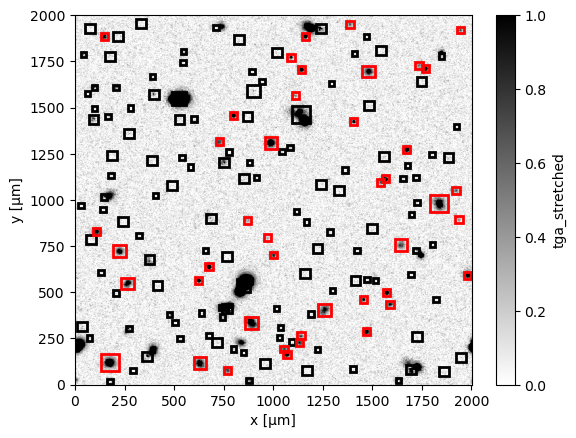

In [49]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [50]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[623.82924141 565.5639073   -2.95687645]

[-8.38725321e-16  1.66263034e-15 -1.42029905e-15]

(37.33270493343974, -26.76897534211576, 2.342018185212267e-15)

0.9968199663186519

[ 798.59887809 1458.87019561   -4.95854179]

[ 1.26581952e-15 -1.24942181e-15  2.96975443e-15]

(-59.08266391598677, 134.62647473229754, 3.461617438478415e-15)

0.9966888595091817

[ 985.86851628 1307.35310615  -17.03199454]

[1.39590785e-14 1.70335650e-14 2.67229312e-14]

(-50.50767268077741, 39.33476333630765, 3.4628214830146824e-14)

0.9982605825160868

[171.05360652 119.03190295 -20.1969358 ]

[-4.30980473e-14 -1.61117008e-16 -4.48240855e-14]

(46.12445419762613, -90.21419257131967, 6.218252391385453e-14)

0.9982143518460282

[675.53361104 640.04795163  -4.70096954]

[-9.78145424e-16  3.23153965e-15 -1.84288970e-15]

(28.62685942641002, -16.840387741639802, 3.84653863408841e-15)

0.9961456218223671

[1573.18014734  495.55651743   -8.97209265]

[-9.86208899e-16  3.98318292e-15  4.89393920e-15]

(-50.02093459441361, -13.906380957358861, 6.386626267608824e-15)

0.9927870637640113

[632.3391693  111.52640484 -15.84602298]

[ 1.22603357e-14 -2.27119747e-14 -1.19416675e-14]

(24.82895400440007, 151.63902218011447, 2.843858379142702e-14)

0.9982316725662096

[1838.94744887  978.80570374  -19.37749622]

[ 1.23136536e-14 -5.39078017e-14 -3.00176786e-15]

(3.10726191221367, 167.13321029017686, 5.537768282561663e-14)

0.9975964829906718

[891.8510443  332.65995492 -18.99678543]

[-2.74447892e-14  3.97649227e-14  8.71665874e-15]

(-10.226627109514846, -34.61250067717403, 4.9096289777447223e-14)

0.9983791056992571

[1141.45217417 1709.33600276   -7.50083097]

[-1.48946676e-15  3.70453989e-15 -2.89581992e-15]

(35.95216932205256, -21.903345522081363, 4.9323321097029085e-15)

0.9959338163684649

[1673.06007913 1276.38967135   -8.13517036]

[-2.52822466e-15  6.16043153e-15 -3.98940350e-15]

(30.925645379050426, -22.31311570425898, 7.762614045644908e-15)

0.9981618941894859

[1769.60936863 1712.73448964   -8.1895052 ]

[ 1.66809155e-15  2.06982655e-15 -4.19276335e-15]

(57.62416505596103, 38.86564852121266, 4.96447136130582e-15)

0.9739435836323778

[1162.8468328  1887.83759735   -4.7555915 ]

[-4.15089784e-17  1.62078060e-15 -3.24795828e-15]

(63.47260037300409, -1.4670520493226078, 3.630135778485612e-15)

0.9670114655886848

[265.33832223 547.1646381  -13.03661713]

[1.06288690e-14 1.27796807e-14 3.12619011e-15]

(-10.651461368522536, 39.75031998313055, 1.6913490426398104e-14)

0.9961966818389445

[1071.105973    162.88511487   -7.85898429]

[ 1.84972501e-15  8.41006048e-17 -4.36802659e-15]

(67.02758485739913, 87.396751716683, 4.744282014760309e-15)

0.9558151713724865

[224.9126739  721.06325714 -14.1976619 ]

[-1.04113489e-15 -8.17516299e-16 -1.40031914e-14]

(84.5997915701396, -128.13958802764418, 1.406561993937047e-14)

0.9962457785084281

[1479.06310926 1693.67676753  -19.67964185]

[1.51812337e-14 9.92577823e-15 2.34167886e-14]

(-52.239458485807305, 56.82258041667489, 2.961987374158549e-14)

0.9964788991895928

[1469.57444049  289.00097759  -10.96852678]

[-3.30799605e-15  6.38841890e-15 -4.91488005e-15]

(34.340276418537265, -27.375635472743525, 8.712679260900648e-15)

0.9969844458200984

[1563.93142445 1115.47132905   -7.54312703]

[-2.37413781e-15  4.89690164e-15 -1.67868382e-15]

(17.143108264347497, -25.865243417833135, 5.695099243719444e-15)

0.9689562392538197

[110.10759954 826.88285341 -14.37985542]

[ 8.45562299e-15 -8.81780004e-15 -8.97287693e-15]

(36.29608983651699, 136.20116182590743, 1.5157957579853446e-14)

0.9968955635071538

[1404.29210121 1424.98193536   -5.65793994]

[2.49896517e-15 2.71578486e-16 1.00355562e-15]

(-21.7637517992702, 83.7976434832807, 2.7066040869552212e-15)

0.993237078806606

[ 145.73743593 1889.02576322  -14.68252235]

[-4.74224012e-15  9.69722916e-15 -7.05646873e-15]

(33.172597031515856, -26.060040122016233, 1.2896466398629933e-14)

0.9933053123915732

[1258.29764027  402.28374806  -18.15484421]

[1.82608632e-14 2.26684363e-14 3.24078109e-15]

(-6.352790186480741, 38.853647766495044, 2.928856076351505e-14)

0.9969027638613144

[1593.08742857  434.62640359   -8.13913042]

[ 3.96205561e-15  5.84336446e-16 -1.55362704e-15]

(21.202777928855475, 81.61031781546757, 4.2957060823454496e-15)

0.992243129524794

[1455.2661886   463.92800291   -8.13804733]

[-9.73789520e-16  2.75023908e-15 -2.08228879e-15]

(35.515911188711996, -19.497756027351272, 3.5844117591250735e-15)

0.9930722234744083

[1088.43080194 1775.17285219   -6.05109171]

[-8.69330049e-16  1.69900259e-15 -1.23134988e-15]

(32.82990358104863, -27.09750113395019, 2.2712479091987137e-15)

0.9891195571019598

[1981.08782512  596.82468157  -18.81182516]

[-6.00104465e-15  1.68753428e-14 -1.71667309e-14]

(43.78513008373355, -19.57590714368161, 2.4808997992532543e-14)

0.9953657940176576

[1132.78795112  230.1829037   -13.81080183]

[-3.02081403e-15  4.71512991e-15 -6.41266557e-15]

(48.87121472836066, -32.64622476894293, 8.513521432164019e-15)

0.9890495434736865

[998.71993713 705.71334077 -14.73101432]

[-4.17742967e-15  7.61749915e-15 -5.52299025e-15]

(32.4449649486155, -28.740323971951945, 1.0294689569129476e-14)

0.9944251995971364

[768.46352669  82.11144938 -17.01846503]

[-3.16316846e-15  9.94419553e-15 -7.17800104e-15]

(34.522783168502514, -17.645447924890842, 1.2665557956351575e-14)

0.9935326329373194

[ 728.98487136 1311.17536688  -18.22336133]

[-2.28189092e-15  1.24100793e-14  9.30040577e-15]

(-36.3927074015414, -10.418825484496256, 1.56752876251464e-14)

0.9903381052330379

[1644.52346117  760.82456798  -18.00020452]

[ 5.76176328e-17  1.62391932e-14 -7.04953273e-15]

(23.465826821015373, 0.2032880135548796, 1.770340723390447e-14)

0.9920785754167517

[1945.18809324 1917.45527054   -6.41450971]

[-4.33522110e-16  9.92137103e-16  1.16404248e-15]

(-47.07300187165375, -23.603300784934596, 1.5897397126782145e-15)

0.9660243540408631

[1138.12960985  265.60021792   -9.76737748]

[-1.15483922e-15  2.78517879e-15 -2.41836067e-15]

(38.73243789580498, -22.52072332886627, 3.865144608965451e-15)

0.9828141139173339

[1056.40689642  185.57447936  -15.03424187]

[ 2.53404089e-15 -4.64869173e-15 -7.67571722e-15]

(55.40316454583347, 151.40482774890592, 9.324608990574076e-15)

0.9622086398193631

[1919.80199389 1054.39513105  -13.86678853]

[-1.62349378e-15  4.98694927e-15 -3.06779366e-15]

(30.325410951059112, -18.032580620663033, 6.075915813054925e-15)

0.9786497273650148

[1385.31420353 1957.27857503  -15.16328858]

[-1.12929405e-15  6.23190708e-15 -3.88284959e-15]

(31.511418194199717, -10.271202171854151, 7.428895737097555e-15)

0.9838323130349989

[1542.93450762 1099.76786703   -8.30278516]

[-4.09633944e-16  2.44069159e-15 -1.40276343e-15]

(29.545102745135623, -9.52745196225506, 2.844735602621807e-15)

0.9776022184891978

[1109.83698985 1571.38561703   -8.97906322]

[-3.04493745e-16  1.47444112e-15 -1.26362698e-15]

(40.007081157015, -11.668386391002652, 1.965565114934241e-15)

0.9619503357619549

[1736.5621654  1731.11546848  -18.10956911]

[-2.88842860e-15  5.95378664e-15 -7.45706161e-15]

(48.41393613416978, -25.879945335572224, 9.969872767697738e-15)

0.9836890205600293

[1935.81347974  896.753648     -6.13408902]

[-1.92373105e-16  5.98359900e-16 -6.89471578e-16]

(47.64763700849413, -17.82263264348173, 9.32959291150661e-16)

0.9426490648611918

[870.03256249 896.14153479 -12.84166729]

[-1.38211335e-15  2.33206972e-15 -1.99618173e-15]

(36.36657568972762, -30.653324649880922, 3.3665305548997813e-15)

0.9412957884830833

[972.12157846 797.19292155  -6.93284906]

[-2.11943922e-16  2.05218683e-16 -6.61023764e-16]

(65.94865370543465, -45.92360741293342, 7.238697049661758e-16)

0.9351199741052276

In [51]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr_enhanced))[1]
z_difference_itr_enhanced = positions_itr_enhanced[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr_enhanced

array([ 6.19841516e-03,  1.23794406e-02, -7.19261308e-03,  4.51322251e-02,
        1.68643004e-01,  6.70150917e-03, -7.92577420e-02,  2.36642534e-03,
        2.10204720e-02,  2.54063121e-02,  2.18217689e-02,  9.64458469e-03,
        1.24060455e-02,  2.25023652e-02,  1.10369601e-01,  8.30359323e-02,
        4.57950637e-02, -7.14366167e-02,  1.20440813e-02,  3.80767212e-02,
        6.22606771e-03, -1.12690640e-01, -7.15138049e-02, -7.33586137e-03,
        1.24141653e-01,  1.58542293e-01,  8.89942203e-02,  6.73960594e-02,
       -5.07146179e-02,  2.03734497e-02,  5.34145348e-02,  7.46161030e-02,
        1.74529646e-02,  1.00463775e-02,  3.78283292e-01,  2.57512408e-01,
        1.93709281e-01, -2.46342598e-01, -1.63911669e-01,  1.59818291e-02,
        2.41726485e-02,  1.61090248e-01, -1.30482318e+00,  8.00399774e-03,
        1.64270345e-01,  9.11500475e-01,  7.60993457e-02,  1.31905865e-01,
        7.90739860e-02,  1.94807839e-01,  2.41302091e-01,  4.85442094e-02,
        2.18839023e-01,  

In [52]:
# Misfits alculation
direction_misfit_itr_euler_enhanced = []
magnetic_moment_misfit_itr_euler_enhanced = []

for estimated, true in zip(estimated_dipole_moments_itr_euler_enhanced, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler_enhanced.append(dir_misfit)
    magnetic_moment_misfit_itr_euler_enhanced.append(magm_mom_misfit)

/tmp/ipykernel_16619/2222737513.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


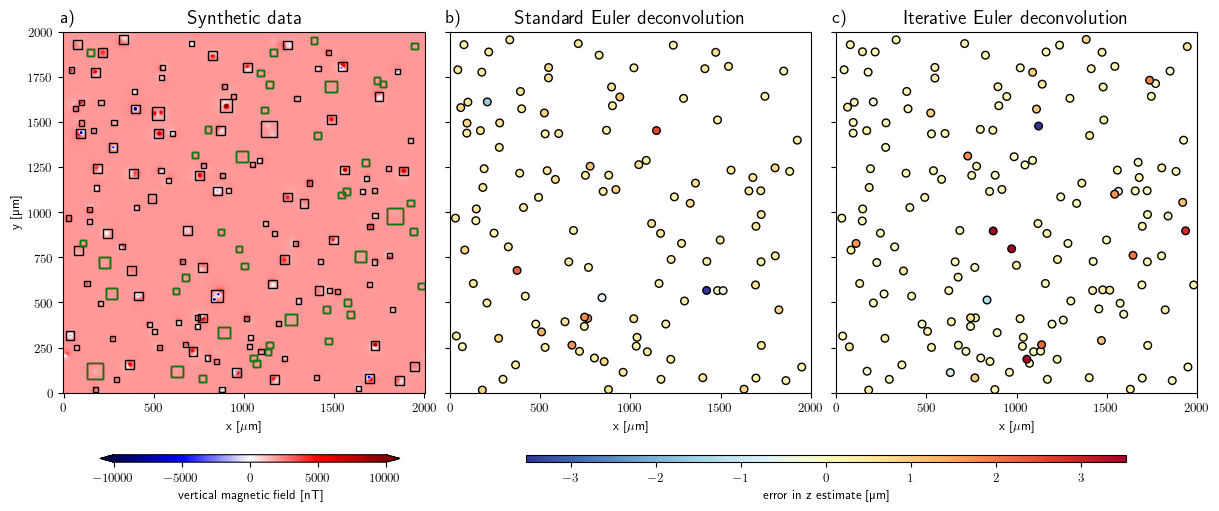

In [60]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-10000, vmax=10000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference))

    ax = axes[1]
    # for window in windows:
    #     rect = matplotlib.patches.Rectangle(
    #         xy=[window[0], window[2]],
    #         width=window[1] - window[0],
    #         height=window[3] - window[2],
    #         edgecolor="k",
    #         fill=False,
    #         linewidth=1.1,
    #     )
    #     ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=z_difference_itr_enhanced, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


/tmp/ipykernel_16619/389122893.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)


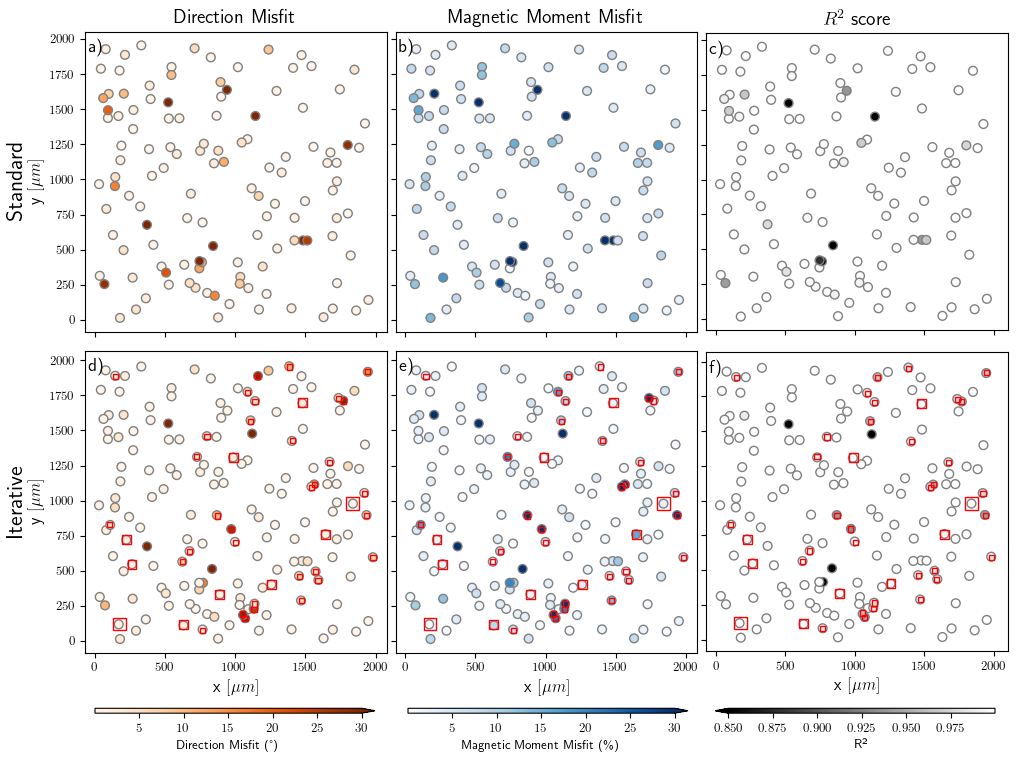

In [54]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=direction_misfit_itr_euler_enhanced, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=magnetic_moment_misfit_itr_euler_enhanced, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=calculated_r2_itr_euler_enhanced, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        if ax == axes[-1] or ax == axes[-2] or ax == axes[-3]:
            for window in non_overlapping_windows:
                rect = matplotlib.patches.Rectangle(
                    xy=[window[0], window[2]],
                    width=window[1] - window[0],
                    height=window[3] - window[2],
                    edgecolor="r",
                    fill=False,
                    linewidth=1,
                )
                ax.add_patch(rect)

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iterative}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[3].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[4].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[5].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    # fig.savefig(fig_dir / "inversion-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   

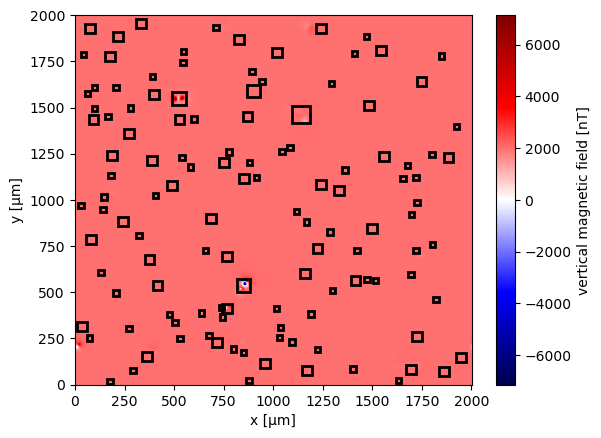

In [55]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

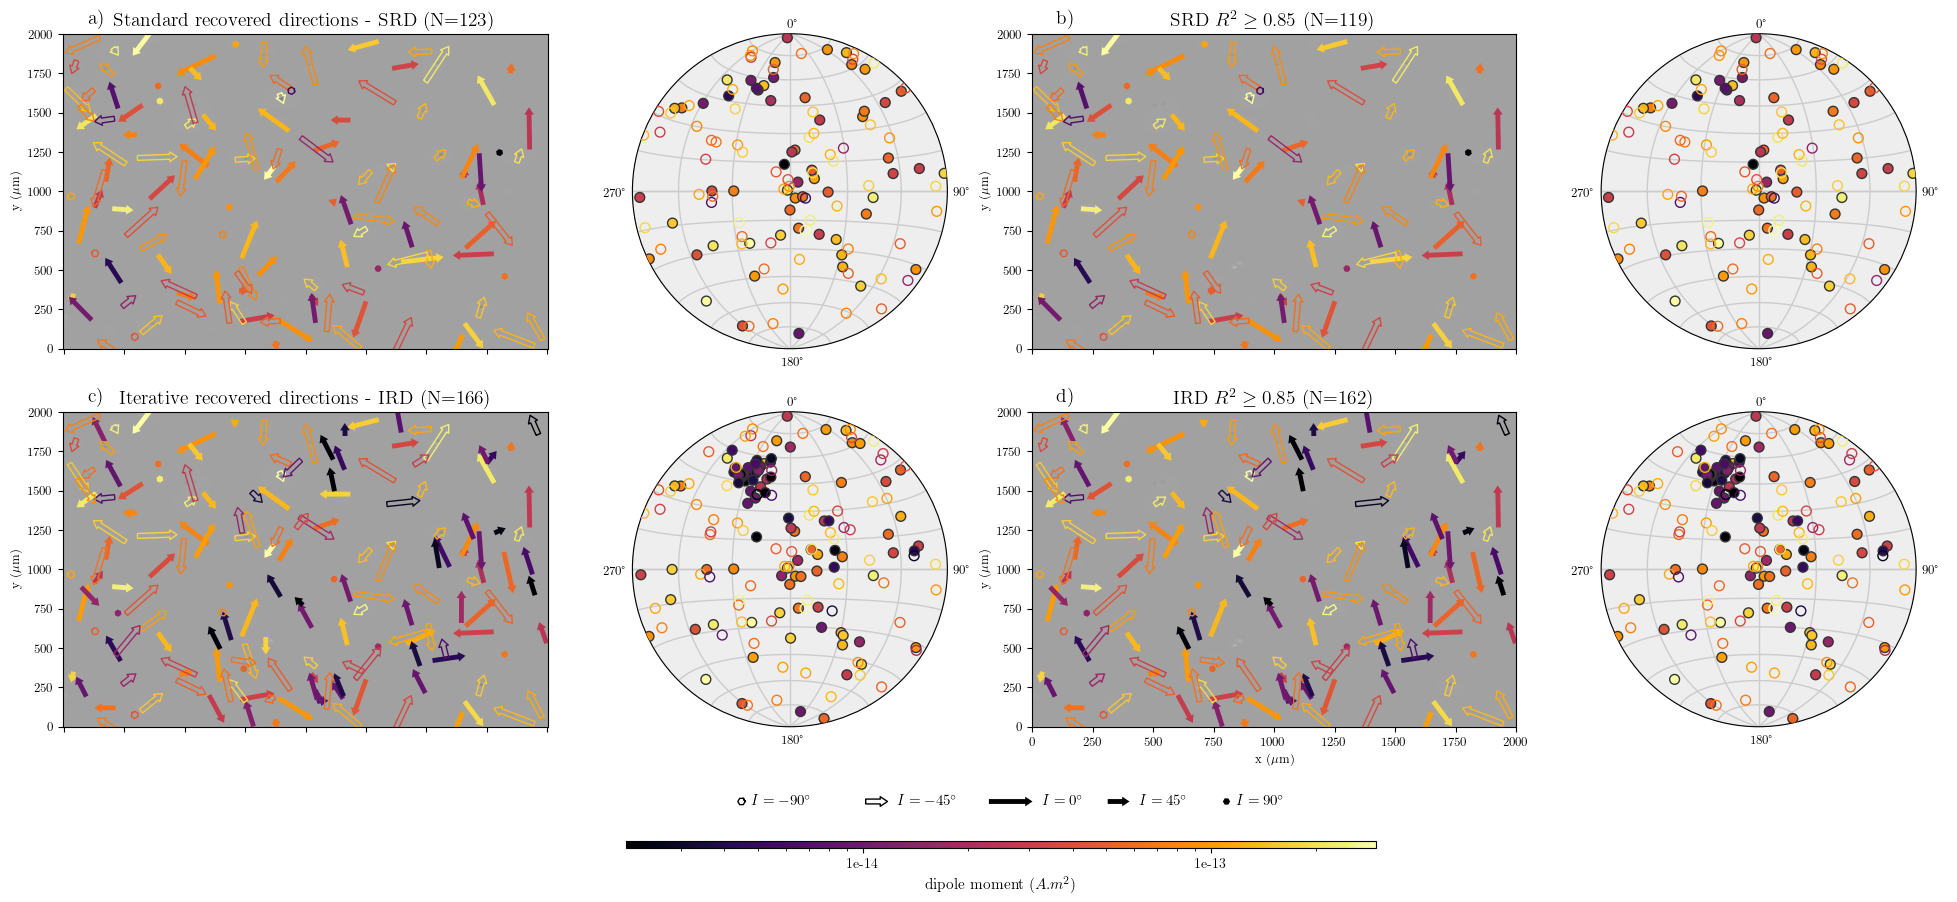

In [58]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    fig.savefig(fig_dir / "synthetic-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

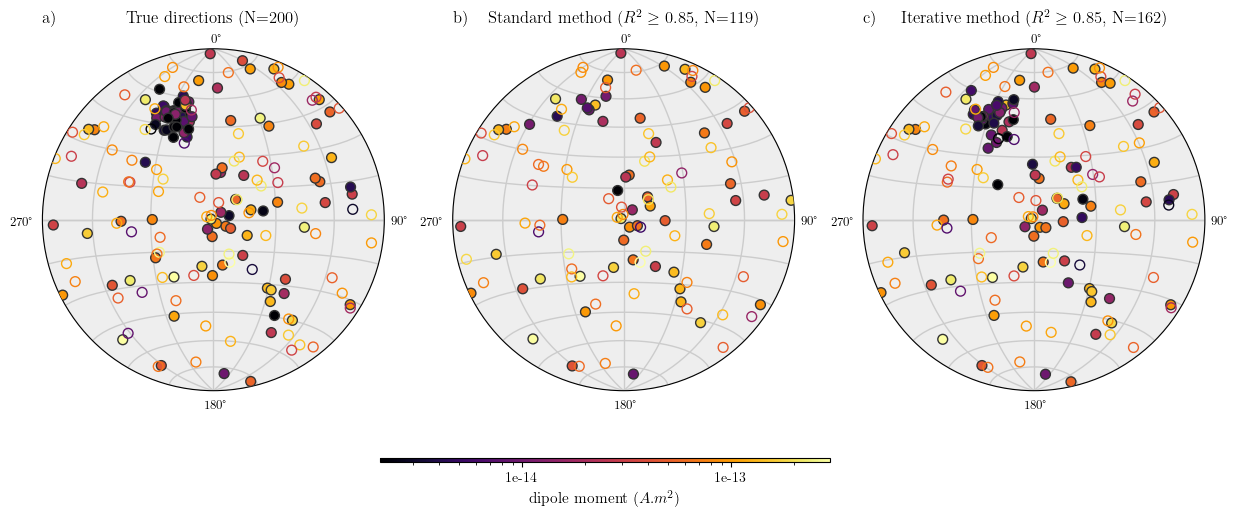

In [57]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(15, 5))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.01, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    N1 = dipole_moments.shape[0]
    ax = fig.add_subplot(1, 3, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=1000, **kwargs, add_ticks=True)  

    #2
    N2 = filter_estimated_d_m.shape[0]
    ax = fig.add_subplot(1, 3, 2, projection='stereonet')
    axes.append(ax) 
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)
    
    #3
    N3 = filter_estimated_d_m_itr.shape[0]
    ax = fig.add_subplot(1, 3, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    
    titles = (f'True directions  (N={N1})'+'\n', 
              f'Standard method  ($R^2 \geq 0.85$, N={N2})'+'\n',
              f'Iterative method ($R^2 \geq 0.85$, N={N3})'+'\n')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.0, 1.0775, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=12)
        # ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.2, hspace=0.0)
    fig.savefig(fig_dir / "synthetic-data-stereograms-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()